In [1]:
import sys
import pandas as pd
import numpy
sys.path.append('../scripts/')
from run_holdout_experiments import createReSTobject, preprocess
import seaborn as sns
from matplotlib import pyplot as plt
import scanpy as sc
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score as sscore
from sklearn.metrics import calinski_harabasz_score as chscore
import numpy as np
from time import sleep
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_clustering_results(data_name, pDir = '../data/', platform='Visium', min_region=None, MIST_only=False):
    np.random.seed(2022)
    
    raw_fn = os.path.abspath(f"{pDir}{data_name}/raw.csv")
    rd = createReSTobject(raw_fn)
    rd.adata = preprocess(rd.adata, hvg_prop=0.8)
    
    if platform == 'Visium':
        min_region = 40
    else:
        min_region = 10
    if min_region is not None:
        min_region = min_region
        
    rd.extract_regions(min_region=min_region, sigma=0.01)
    plt.close()
    radata = rd.adata.copy()
    
    n_clusters = set(radata.obs.region_ind)
    n_clusters.remove("isolated")
    n_clusters = len(n_clusters)
    # n_clusters = [n_clusters - 1, n_clusters, n_clusters + 1]
    sc.pp.neighbors(radata)
    sc.tl.umap(radata)
    sc.tl.leiden(radata)
    cluster_results = radata.obs[['region_ind','leiden']].copy()
    # # extract pca coordinates
    X_pca = radata.obsm['X_pca']
    
    if not MIST_only:
        cluster_results['KMeans'] = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca).labels_.astype(str)
        cluster_results['hClust'] = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(X_pca).astype(str)

        bayesSpace_fn0 = os.path.abspath(f"{pDir}{data_name}/bayesSpace_cluster_instruction_parameters.csv")
        bayesSpace_fn1 = os.path.abspath(f"{pDir}{data_name}/bayesSpace_cluster_comparable_parameters.csv")

        rcmd0 = f'Rscript runBayesSpace.R --input {raw_fn} --output {bayesSpace_fn0} --q {n_clusters} --platform {platform} --d 7 --nhvgs 2000'
        rcmd1 = f'Rscript runBayesSpace.R --input {raw_fn} --output {bayesSpace_fn1} --q {n_clusters} --platform {platform} --d 30 --nhvgs {int(0.8 * radata.shape[1])}'

        rcmds = [rcmd0, rcmd1]
        bayesSpace_fns = [bayesSpace_fn0, bayesSpace_fn1]
        cmd_types =  ['instructed', 'comparable']

        for k, (rcmd, bayesSpace_fn) in enumerate(zip(rcmds, bayesSpace_fns)):
            os.system(rcmd)
            print(f"[{data_name}] Start running BayesSpace ... [checkpoint=0]")
            checkpoint=1

            while (not os.path.exists(bayesSpace_fn)):
                sleep(60)
                print(f"[{data_name}] Start running BayesSpace ... [checkpoint={checkpoint}]")
                checkpoint += 1
                if checkpoint > 10:
                    break

            if os.path.exists(bayesSpace_fn):
                print(f"[{data_name}] Finished running BayesSpace {cmd_types[k]} ...")
                bs_res = pd.read_csv(bayesSpace_fn, index_col=0)
                cluster_results[f'BayesSpace {cmd_types[k]}'] = bs_res.loc[cluster_results.index,'spatial.cluster'].astype(str)
                os.remove(bayesSpace_fn)
            else:
                print(f"[{data_name}] BayesSpace encountered some issues")

        print(f"[{data_name}] all methods' clustering results obtained.")

        cluster_results.rename(columns={'region_ind': 'MIST'}, inplace=True)
    
    sscores, sspatials, modelnames = [], [], []
    for model in cluster_results.columns:
        if model == 'MIST':
            rmist = radata[radata.obs.region_ind != 'isolated']
            x_pca = rmist.obsm['X_pca']
            coords = rmist.obs[['array_col', 'array_row']]
            
            labels = cluster_results.loc[rmist.obs.index, model]
        else:
            x_pca = radata.obsm['X_pca']
            coords = radata.obs[['array_col', 'array_row']]
            labels = cluster_results.loc[radata.obs.index, model]
            
        sscores.append(sscore(x_pca, labels, metric='correlation'))
        sspatials.append(sscore(coords, labels))
        
    model_perfs = pd.DataFrame({'model': cluster_results.columns.tolist(),
                                'silhouette coefficient': sscores,
                               'silhouette spatial': sspatials})
    
    model_perfs = model_perfs.sort_values('silhouette coefficient', ascending=False)
    
    cluster_results.to_csv(f"{pDir}{data_name}/cluster_results_all_methods.csv")
    model_perfs.to_csv(f"{pDir}{data_name}/cluster_silhouette_all_methods.csv")
    return cluster_results, model_perfs

In [3]:
data_names = ['Human_Breast_Cancer_BAS1',
 'Human_Prostate_Cancer_Acinar_Cell_Carcinoma_FFPE',
 'Human_Breast_Cancer_BAS2',
 'Human_Breast_Cancer_Ductal_Carcinoma_FFPE',
 'Human_Glioblastoma',
 'Melanoma',
 'MouseAD',
 'Human_Invasive_Ductal_Carcinoma',
 'Human_Ovarian_Cancer',
 'MouseWT',
 'Human_Colorectal_Cancer',
 'Human_Prostate_Cancer_Adenocarcinoma_FFPE', 'Prostate']


for data_name in data_names:
    if data_name in ['MouseWT', 'MouseAD', 'Melanoma', 'Prostate']:
        platform = 'ST'
    else:
        platform = 'Visium'
    _, _ = get_clustering_results(data_name, platform=platform)

  0%|          | 0/9 [00:00<?, ?it/s]

MIST Data created in 1.41 seconds.


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Epsilon 0.500 is selected in 4.84 seconds.
[Prostate] Start running BayesSpace ... [checkpoint=0]
[Prostate] Finished running BayesSpace instructed ...
[Prostate] Start running BayesSpace ... [checkpoint=0]
[Prostate] Finished running BayesSpace comparable ...
[Prostate] all methods' clustering results obtained.


In [5]:
res_dfs = []
for data_name in data_names:
    res_fn = f'../data/{data_name}/cluster_silhouette_all_methods.csv'
    louv_fn =f'../data/{data_name}/louvain_silhouette.csv'
    res = pd.read_csv(res_fn, index_col=0)
    res['data'] = data_name
    louv_res = pd.read_csv(louv_fn, index_col=0)
    louv_res = louv_res.loc[louv_res.model == 'louvain']
    louv_res['data'] = data_name
    res['silhouette combined'] = res['silhouette coefficient'] + res['silhouette spatial']
    louv_res['silhouette combined'] = louv_res['silhouette coefficient'] + louv_res['silhouette spatial']
    res_dfs.append(res)
    res_dfs.append(louv_res)
res_dfs = pd.concat(res_dfs)
res_dfs

,model,silhouette coefficient,silhouette spatial,data,silhouette combined
0,MIST,0.263163,0.004369,Human_Breast_Cancer_BAS1,0.267532
3,hClust,0.192719,-0.027068,Human_Breast_Cancer_BAS1,0.165651
2,KMeans,0.181211,-0.025963,Human_Breast_Cancer_BAS1,0.155248
1,leiden,0.180806,-0.063790,Human_Breast_Cancer_BAS1,0.117016
4,BayesSpace instructed,0.101317,0.121240,Human_Breast_Cancer_BAS1,0.222557
...,...,...,...,...,...
3,hClust,0.085274,0.005428,Prostate,0.090702
1,leiden,0.075407,-0.082502,Prostate,-0.007095
4,BayesSpace instructed,0.069953,0.097511,Prostate,0.167464
5,BayesSpace comparable,0.032108,0.200192,Prostate,0.232300


In [6]:
sil_df = res_dfs[['model', 'silhouette coefficient']]
spatial_sil_df = res_dfs[['model', 'silhouette spatial']]
combined_sil_df = res_dfs[['model', 'silhouette combined']]

sil_df.columns=['model', 'silhouette']
sil_df['feature'] = 'Transcriptome'

spatial_sil_df.columns=['model', 'silhouette']
spatial_sil_df['feature'] = 'Spatial'

combined_sil_df.columns=['model', 'silhouette']
combined_sil_df['feature'] = 'Combined'


sil_dfs = pd.concat([sil_df, spatial_sil_df, combined_sil_df])
sil_dfs.model.replace("BayesSpace instructed", "BayesSpace (I)", inplace=True)
sil_dfs.model.replace("BayesSpace comparable", "BayesSpace (C)", inplace=True)
sil_dfs.model.replace("hClust", "HClust", inplace=True)
sil_dfs.model.replace("leiden", "Leiden", inplace=True)
sil_dfs.model.replace("louvain", "Louvain", inplace=True)

In [24]:
from scipy.stats import ttest_rel

other_models = set(sil_dfs.model)
other_models.remove('MIST')
mist_spatial = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Spatial'),
                           'silhouette'].to_numpy()
mist_transcriptome = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Transcriptome'),
                                 'silhouette'].to_numpy()
mist_combined = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Combined'),
                            'silhouette'].to_numpy()

summary_results = [pd.DataFrame(data=[['MIST', np.median(mist_spatial), 
                                       np.median(mist_transcriptome), 
                                       np.median(mist_combined),
                                       0,0,0,
                                       0,0,0,
                                       1, 1, 1]],
                        columns=['Model', 'Median SSC', 'Median TSC', 'Median CSC',
                                 'dSSC', 'dTSC','dCSC',
                                 'pct_dSCC', 'pct_dTSC','pct_dCSC',
                                 'P-value (SSC)', 'P-value (TSC)', 'P-value (CSC)'])]

for model in list(other_models):
    m_spatial = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Spatial'),'silhouette'].to_numpy()
    m_transcriptome = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Transcriptome'),
                                  'silhouette'].to_numpy()
    m_combined = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Combined'),
                                  'silhouette'].to_numpy()
    
    spatial_diff = np.median(m_spatial - mist_spatial)
    trans_diff = np.median(m_transcriptome - mist_transcriptome)
    comb_diff = np.median(m_combined - mist_combined)
    
    pct_spatial = np.absolute(100 * spatial_diff / np.median(mist_spatial))
    pct_trans = np.absolute(100 * trans_diff / np.median(mist_transcriptome))
    pct_comb = np.absolute(100 * comb_diff / np.median(mist_combined))
    ps = ttest_rel(m_spatial, mist_spatial)[1]
    pt = ttest_rel(m_transcriptome, mist_transcriptome)[1]
    pc = ttest_rel(m_combined, mist_combined)[1]
    
    summary_results.append(pd.DataFrame(data=[[model, 
                                               np.median(m_spatial), 
                                               np.median(m_transcriptome),
                                               np.median(m_combined),
                                   spatial_diff, trans_diff, comb_diff,
                                    pct_spatial, pct_trans, pct_comb,
                                    ps, pt, pc]],
                        columns=['Model', 'Median SSC', 'Median TSC','Median CSC',
                                 'dSSC', 'dTSC','dCSC', 'pct_dSSC', 'pct_dTSC','pct_dCSC',
                                 'P-value (SSC)', 'P-value (TSC)', 'P-value (CSC)']))
summary_results = pd.concat(summary_results)
summary_results.set_index("Model", inplace=True, drop=True)

In [20]:
summary_results.loc[['MIST', 'BayesSpace (C)', 'BayesSpace (I)',
                     'HClust', 'Louvain', 'Leiden', 'KMeans'], 
                    ['Median TSC', 'dTSC', 'pct_dTSC', 'P-value (TSC)']]

,Median TSC,dTSC,pct_dTSC,P-value (TSC)
Model,,,,
MIST,0.263163,0.000000,0.000000,1.000000
BayesSpace (C),0.057069,-0.185355,70.433430,0.000809
BayesSpace (I),0.072738,-0.161846,61.500157,0.005563
HClust,0.116857,-0.070444,26.768356,0.076195
Louvain,0.120589,-0.086153,32.737446,0.023881
Leiden,0.095103,-0.110324,41.922271,0.021476
KMeans,0.185269,-0.066425,25.240964,0.428733


In [25]:
summary_results.loc[['MIST', 'BayesSpace (C)', 'BayesSpace (I)',
                     'HClust', 'Louvain', 'Leiden', 'KMeans'], 
                    ['Median SSC', 'dSSC', 'pct_dSSC', 'P-value (SSC)']]

,Median SSC,dSSC,pct_dSSC,P-value (SSC)
Model,,,,
MIST,0.259224,0.000000,NaN,1.000000
BayesSpace (C),0.059839,-0.133510,51.503562,0.058325
BayesSpace (I),0.080970,-0.183766,70.890596,0.044285
HClust,-0.034805,-0.243058,93.763699,0.004920
Louvain,-0.049731,-0.260800,100.608012,0.000436
Leiden,-0.082502,-0.254753,98.275357,0.000261
KMeans,-0.025963,-0.282346,108.919824,0.005559


In [26]:
summary_results.loc[['MIST', 'BayesSpace (C)', 'BayesSpace (I)',
                     'HClust', 'Louvain', 'Leiden', 'KMeans'], 
                    ['Median CSC', 'dCSC', 'pct_dCSC', 'P-value (CSC)']]

,Median CSC,dCSC,pct_dCSC,P-value (CSC)
Model,,,,
MIST,0.476627,0.000000,0.000000,1.000000
BayesSpace (C),0.083769,-0.395698,83.020600,0.001598
BayesSpace (I),0.132243,-0.321798,67.515802,0.003775
HClust,0.086581,-0.220182,46.195977,0.004480
Louvain,0.095434,-0.327600,68.733030,0.000157
Leiden,0.011371,-0.386109,81.008669,0.000147
KMeans,0.152012,-0.146488,30.734237,0.011755


In [9]:
sil_dfs.loc[(sil_dfs.model == 'BayesSpace (C)') & (sil_dfs.feature == 'Spatial'), 'silhouette'].median()

0.05983912780692

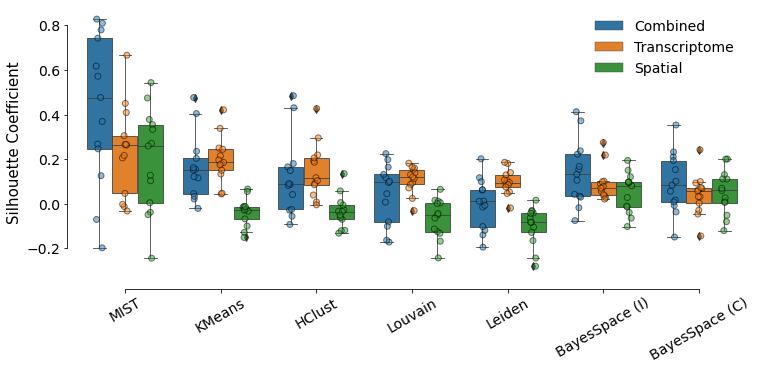

In [16]:
f = plt.figure(figsize=(12,5))
g = sns.boxplot(data=sil_dfs, x='model', y='silhouette',
                order=['MIST', 'KMeans', 'HClust', 'Louvain', 
                       'Leiden', 'BayesSpace (I)', 'BayesSpace (C)'],
                hue='feature', linewidth=0.8, hue_order=['Combined', 'Transcriptome', 'Spatial'])

sns.stripplot(data=sil_dfs, x='model', y='silhouette', hue='feature',
              order=['MIST', 'KMeans', 'HClust', 'Louvain', 
                       'Leiden', 'BayesSpace (I)', 'BayesSpace (C)'],
              dodge=True, size=6, c='pink', alpha=0.5, edgecolor='black', linewidth=1,
              hue_order=['Combined', 'Transcriptome', 'Spatial'])

h, l = g.get_legend_handles_labels()
plt.legend(h[:3], l[:3], fontsize=14, frameon=False)

sns.despine(offset=10, trim=True);
plt.tick_params(axis='both', labelsize=14);
plt.tick_params(axis='x', labelrotation=30);
plt.ylabel("Silhouette Coefficient", fontsize=15);
plt.xlabel("");
plt.savefig("../figures/Figure2-clustering-silhouttee-coefficient_with_combined.png", dpi=200, bbox_inches='tight')